<a href="https://colab.research.google.com/github/EnoshVechalapu/DeepLearning/blob/main/Kaggle_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with Pytorch**

This notebook focuses on building an image classifier for detecting playing cards. We'll break down our approach into three essential components:

* Dataset: Define how data will be loaded and preprocessed for
training and validation.

* Model: Construct the neural network architecture that will learn to classify playing cards.

* Training Loop: Implement the process that trains our model using the defined dataset and model.

Let's dive in and start building our image classifier!




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

### Downloading the dataset from kaggle
Acknowledge the source of the dataset:
This dataset is provided by gpiosenka on Kaggle. Full credit goes to the original authors and contributors.

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()


!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

!unzip cards-image-datasetclassification.zip

import pandas as pd

Streaming output truncated to the last 5000 lines.
  inflating: train/jack of spades/059.jpg  
  inflating: train/jack of spades/060.jpg  
  inflating: train/jack of spades/061.jpg  
  inflating: train/jack of spades/062.jpg  
  inflating: train/jack of spades/063.jpg  
  inflating: train/jack of spades/064.jpg  
  inflating: train/jack of spades/065.jpg  
  inflating: train/jack of spades/066.jpg  
  inflating: train/jack of spades/067.jpg  
  inflating: train/jack of spades/068.jpg  
  inflating: train/jack of spades/069.jpg  
  inflating: train/jack of spades/070.jpg  
  inflating: train/jack of spades/071.jpg  
  inflating: train/jack of spades/072.jpg  
  inflating: train/jack of spades/073.jpg  
  inflating: train/jack of spades/074.jpg  
  inflating: train/jack of spades/075.jpg  
  inflating: train/jack of spades/076.jpg  
  inflating: train/jack of spades/077.jpg  
  inflating: train/jack of spades/078.jpg  
  inflating: train/jack of spades/079.jpg  
  inflating: train/jack o

In [ ]:
Dataframe = pd.read_csv('/content/cards.csv')
Dataframe.head()

class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train

## Dataset (and Dataloader)
 PlayingCardDataset is a custom dataset class built using PyTorch's Dataset class as a base.

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
# Creating Train dataset

dataset = PlayingCardDataset('/content/train')

In [ ]:
len(dataset)

7624

### Get a dictionary associating target values with folder names

In [ ]:
data_dir = '/content/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/content/train'
dataset = PlayingCardDataset(data_dir, transform)

DataLoaders : It's faster to train the model in batches instead of one at a time.

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    break
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels

tensor([47, 14, 35, 51, 36,  2, 25,  5, 40, 34, 51, 43, 10, 41, 12, 12, 27, 27,
        41, 36, 26, 15,  0, 10, 31, 50, 40,  0, 10, 29, 51, 19])

## Model
ResNet-18 is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database .



In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Load a pretrained ResNet-18 model

        self.base_model = models.resnet34(pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        resnet_out_size = self.base_model.fc.in_features

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(resnet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]


SimpleCardClassifer(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (


In [ ]:
example_out = model(images)
example_out.shape

torch.Size([32, 53])

## Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/train'
valid_folder = '/content/valid'
test_folder = '/content/train'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
num_epochs = 15
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/15 - Train loss: 1.9186355722413357, Validation loss: 2.1695197222367772


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/15 - Train loss: 0.9271719449464572, Validation loss: 0.5610075851656356


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/15 - Train loss: 0.6226755497588191, Validation loss: 0.38516454989055415


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/15 - Train loss: 0.4687783048104139, Validation loss: 0.303204888780162


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/15 - Train loss: 0.3463827181775572, Validation loss: 0.1964092543664968


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/15 - Train loss: 0.253544858407624, Validation loss: 0.18330667339405923


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/15 - Train loss: 0.23815554527395794, Validation loss: 0.2019353373995367


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/15 - Train loss: 0.2015007065622779, Validation loss: 0.1634126169712476


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/15 - Train loss: 0.17546476546092524, Validation loss: 0.22153502826420765


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15 - Train loss: 0.14147985249695222, Validation loss: 0.291101961540726


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15 - Train loss: 0.1304368145435517, Validation loss: 0.2535339443751101


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15 - Train loss: 0.09357250965193524, Validation loss: 0.3961385373236998


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15 - Train loss: 0.1118831760342871, Validation loss: 0.21485043288964145


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/15 - Train loss: 0.10057372755809821, Validation loss: 0.299278217550578


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/15 - Train loss: 0.0865424376172634, Validation loss: 0.2012523424618368


Visualise losses

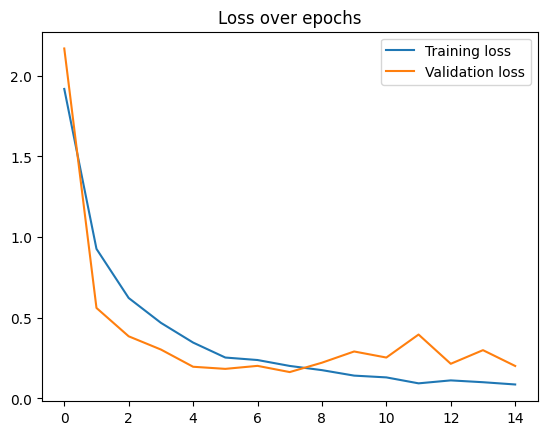

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()


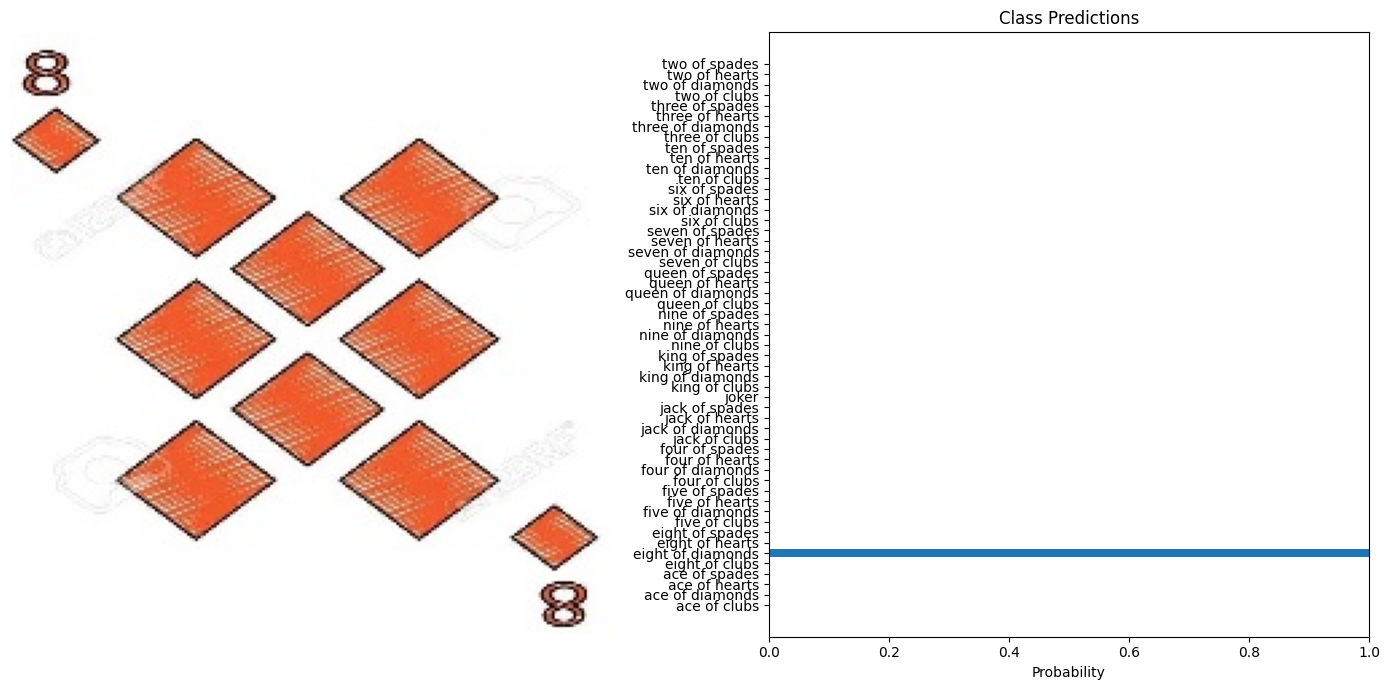

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/content/test/eight of diamonds/5.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

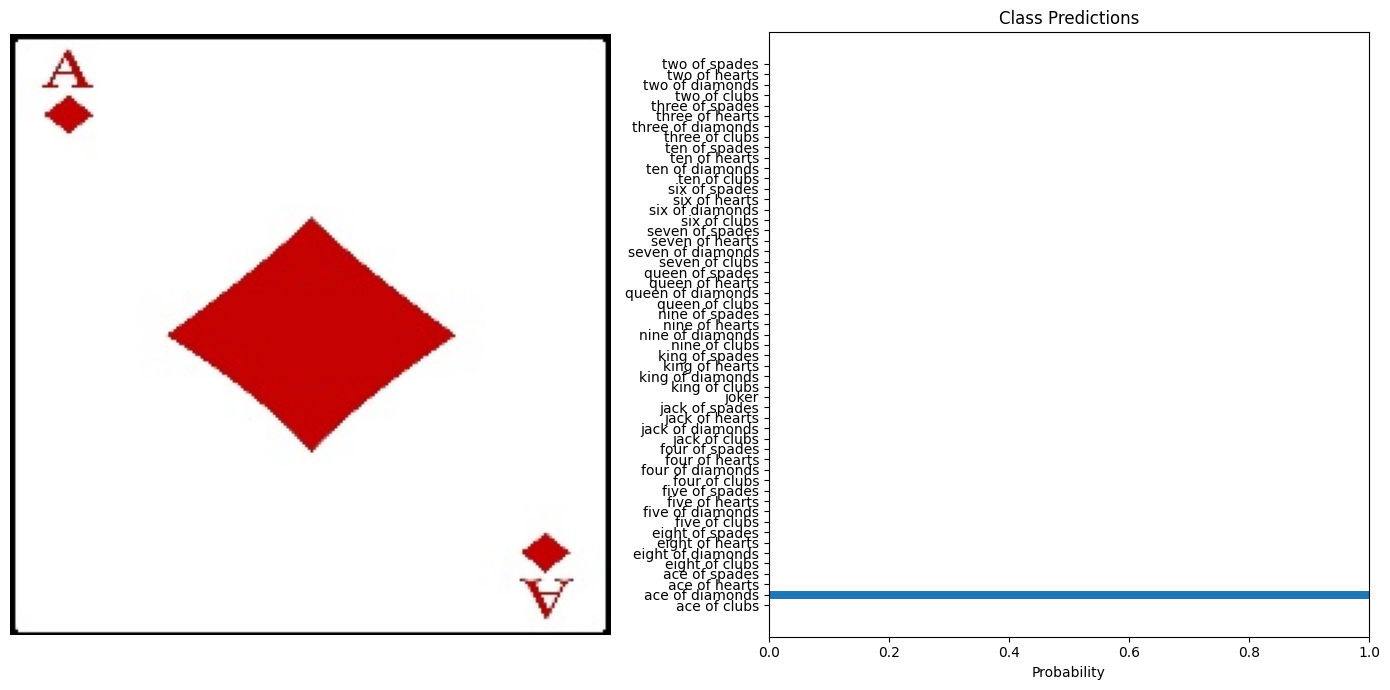

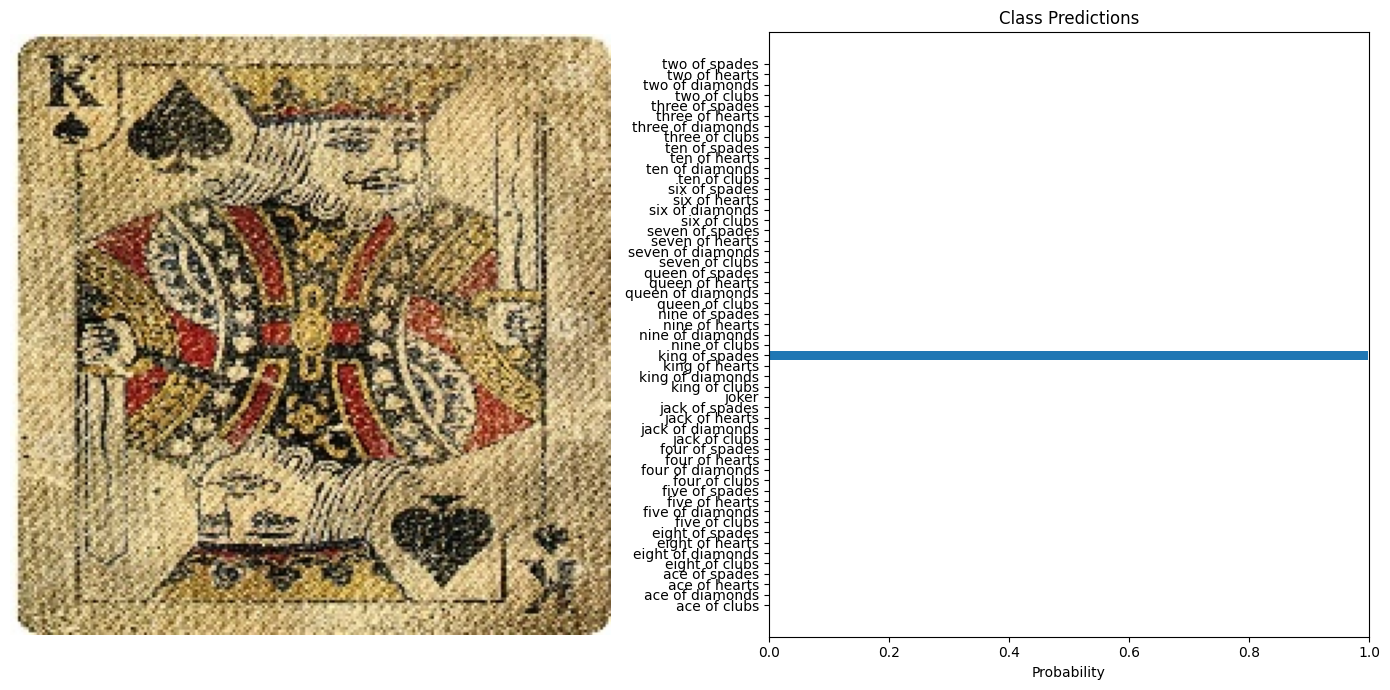

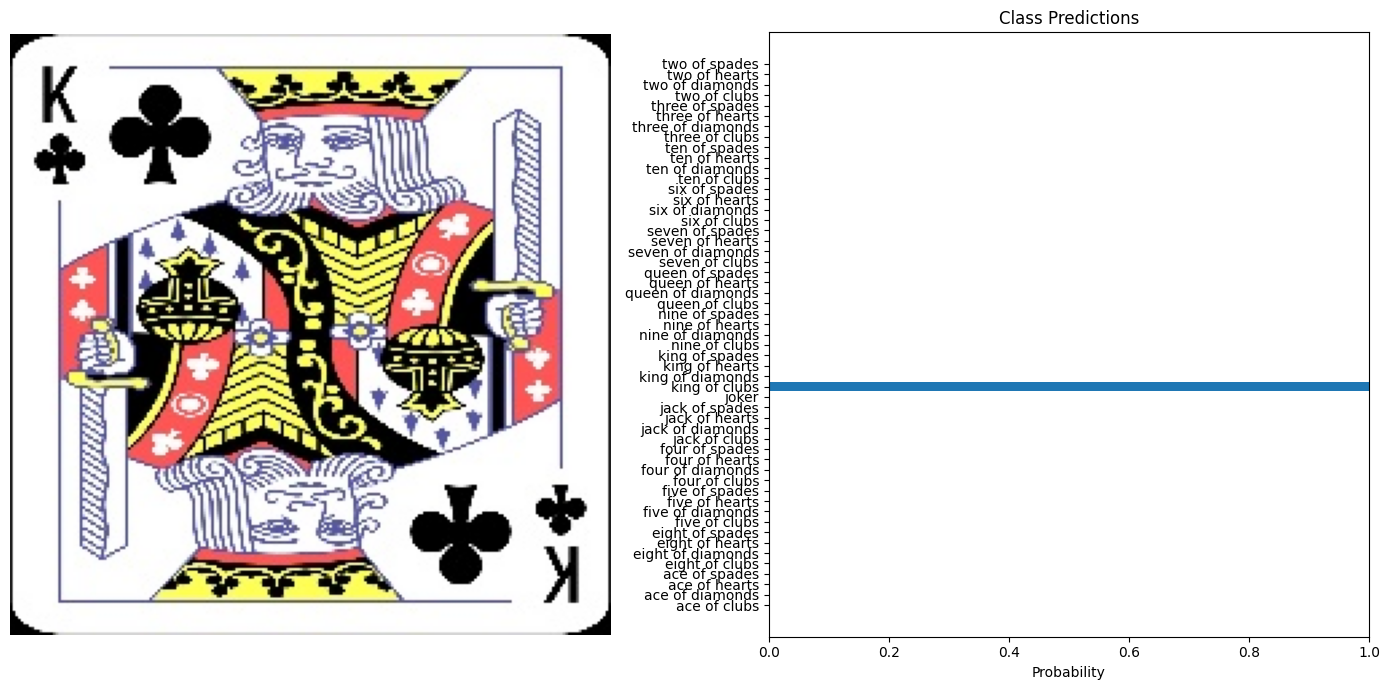

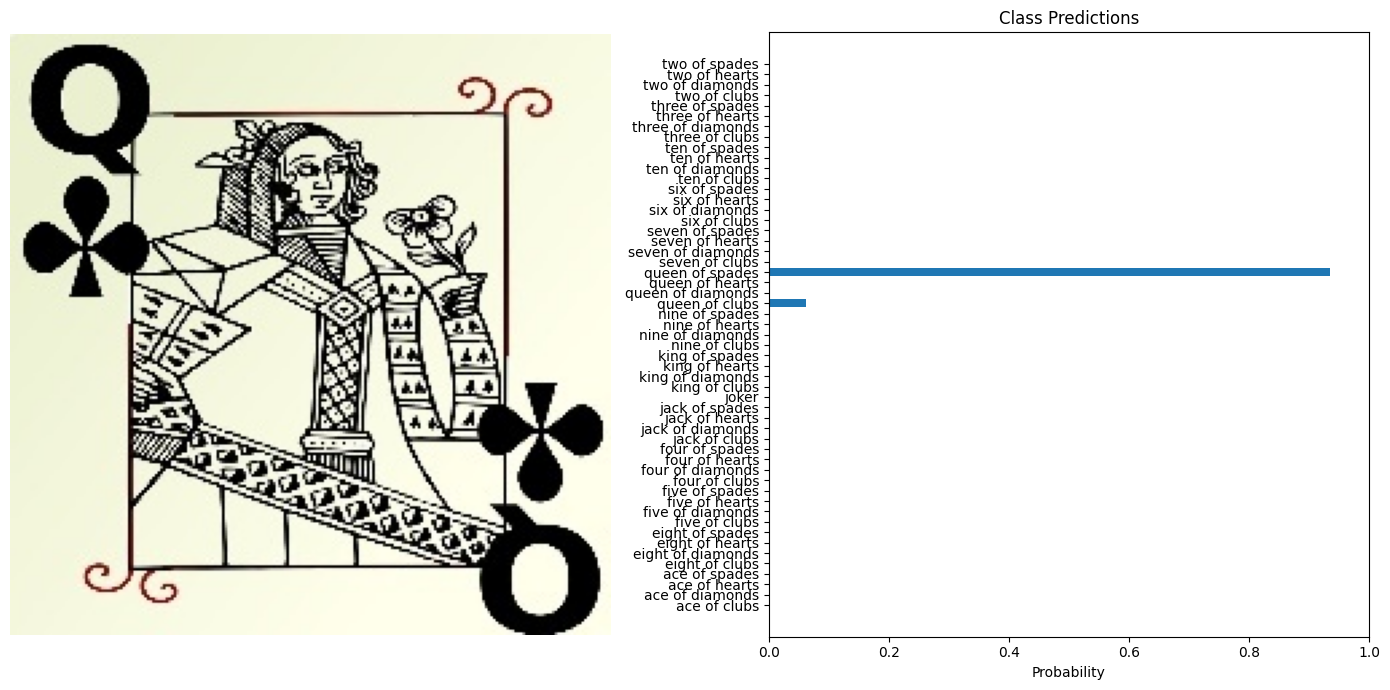

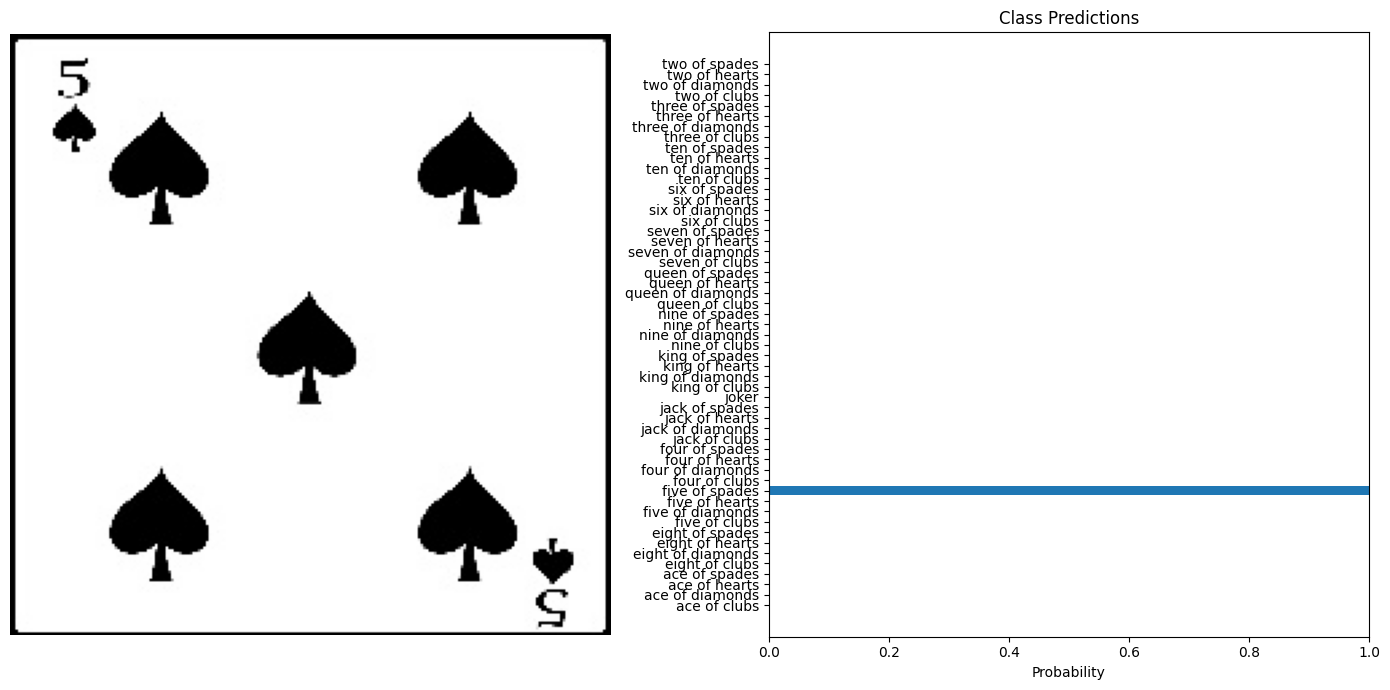

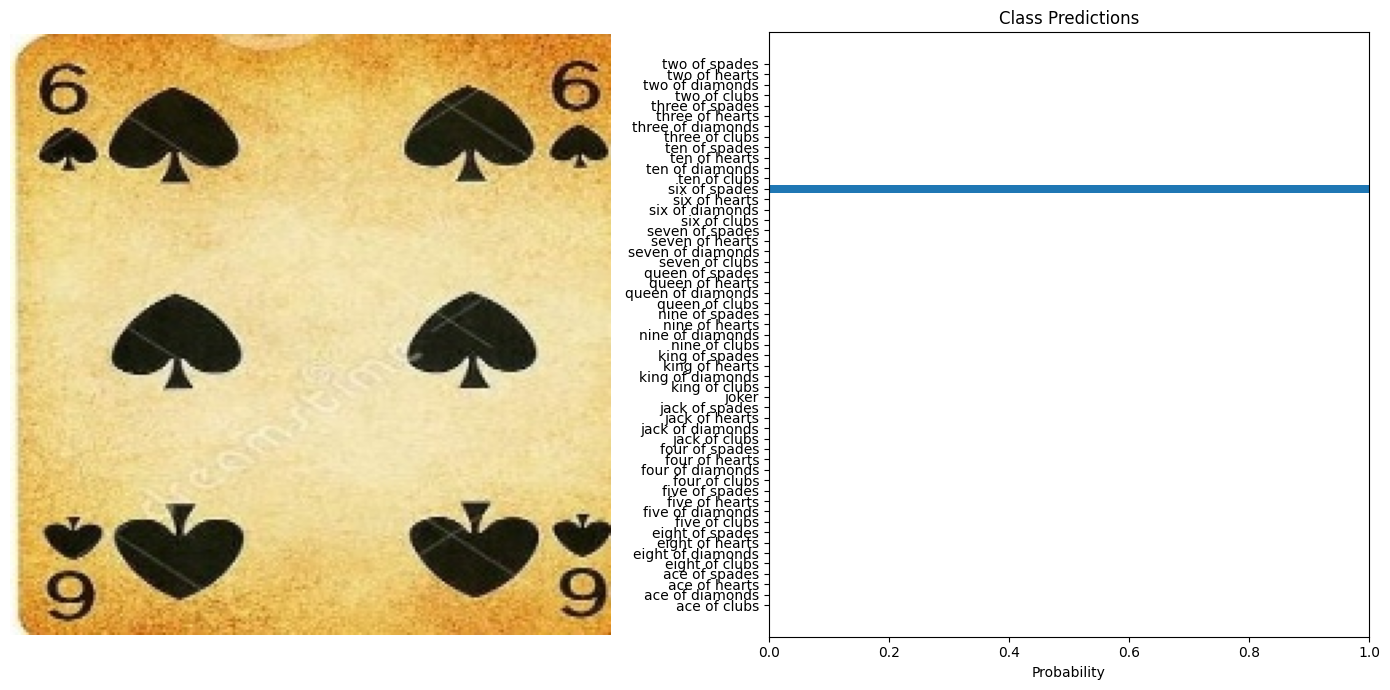

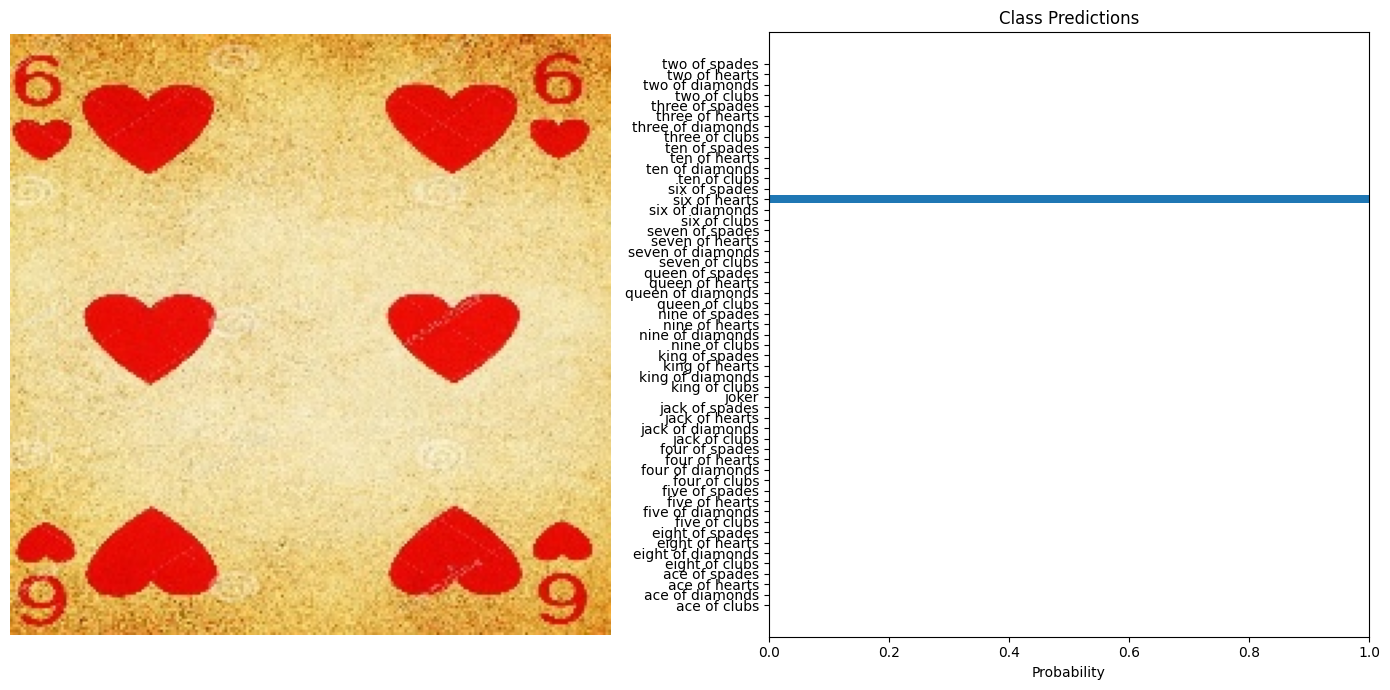

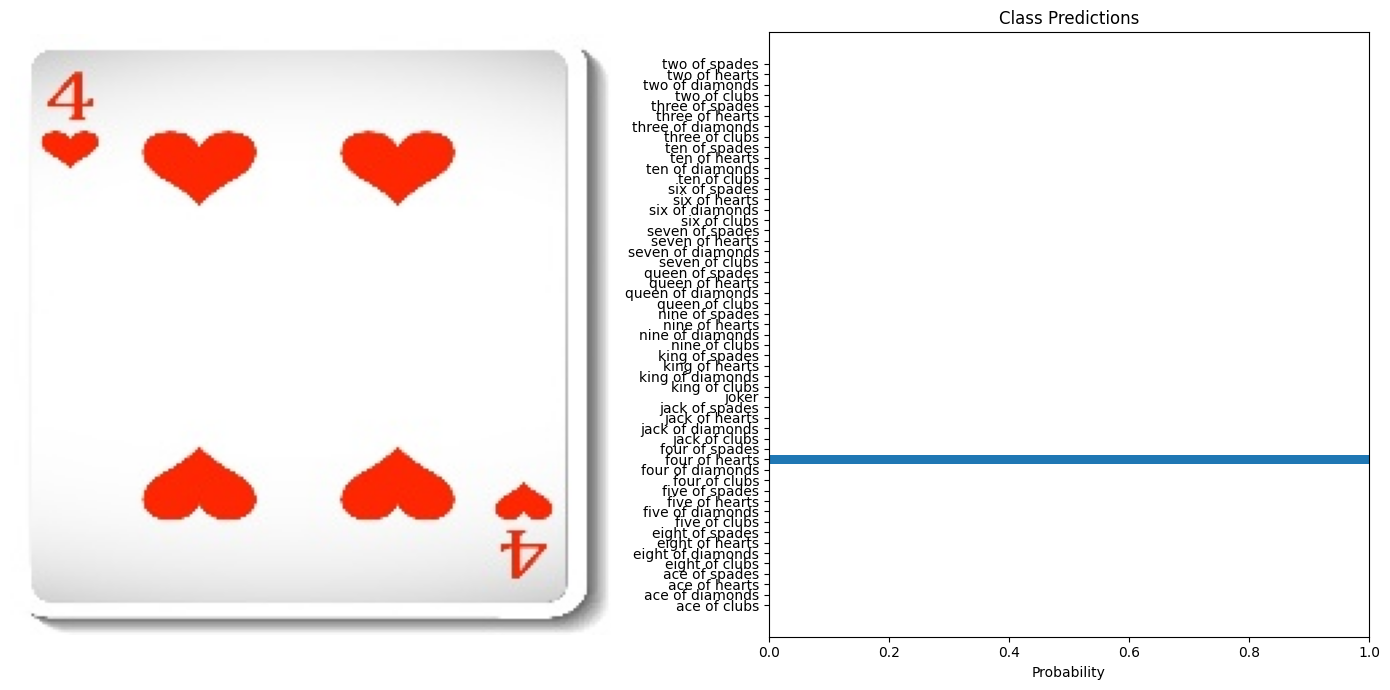

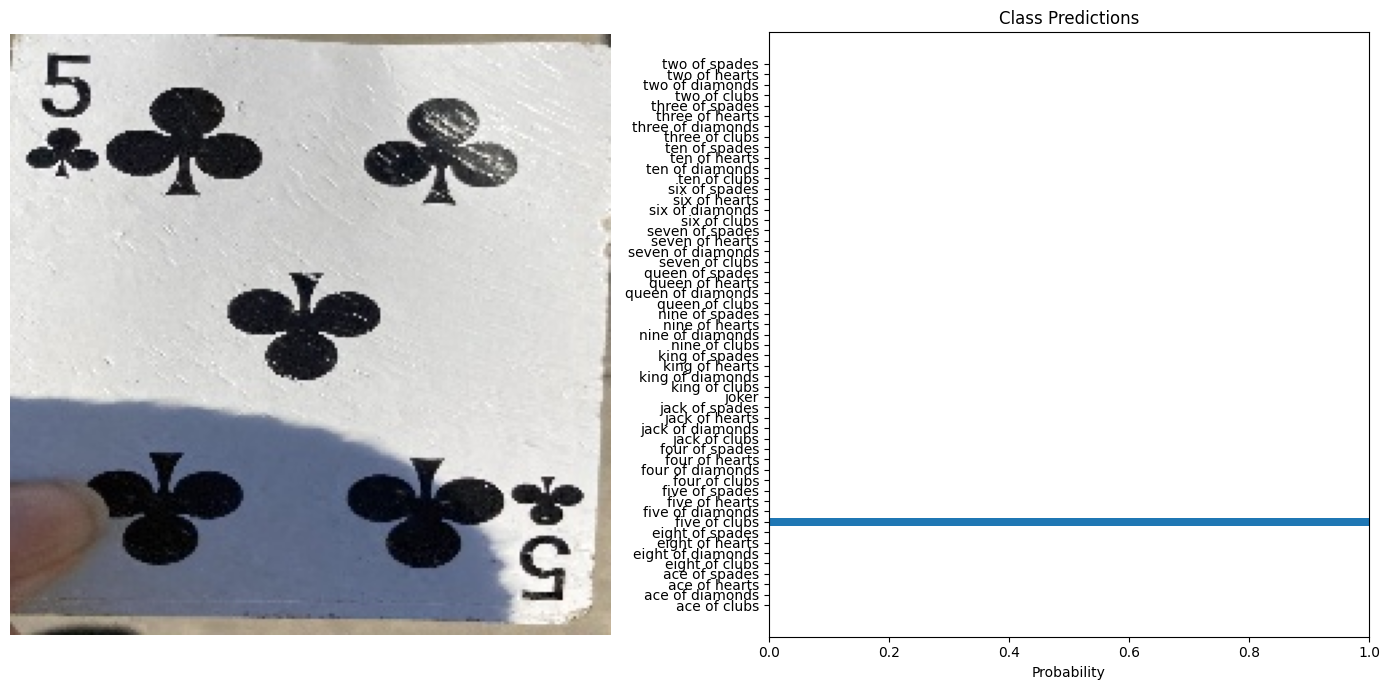

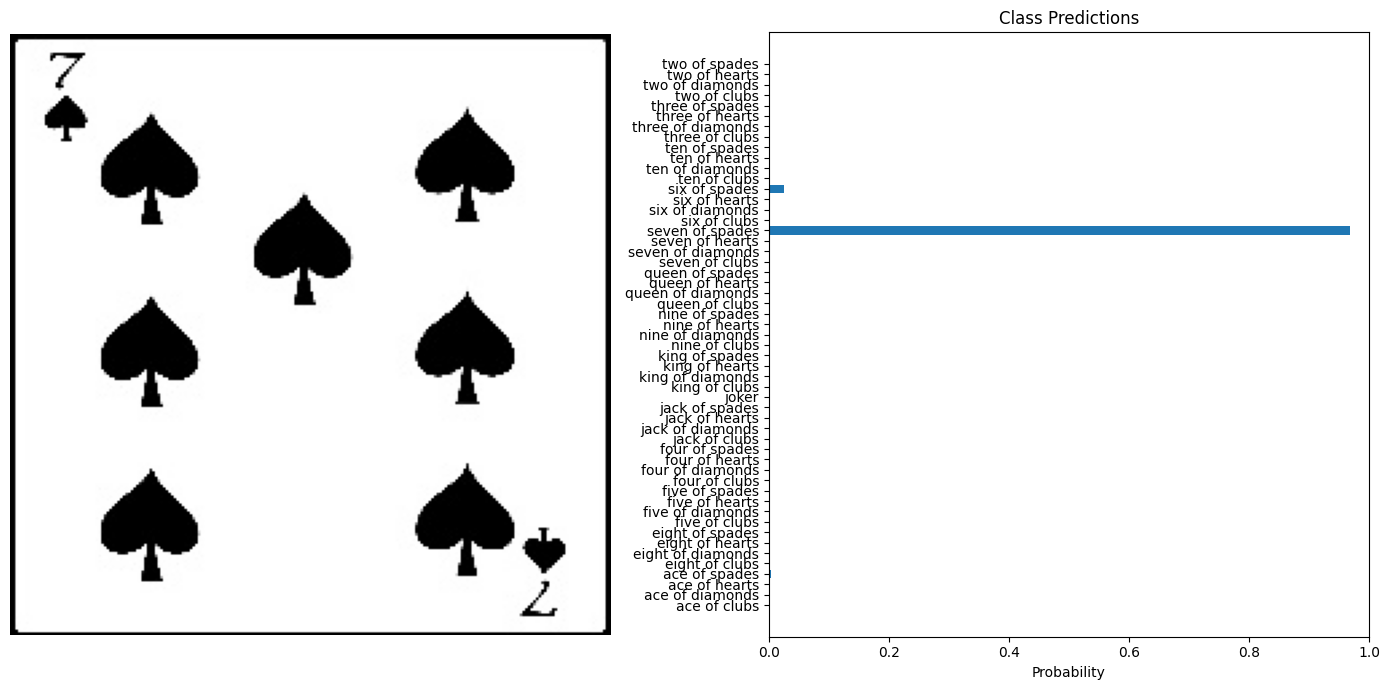

In [ ]:
from glob import glob
test_images = glob('/content/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)

In [ ]:
model.eval()
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
test_accuracy = correct_preds / total_preds

print(f"Test accuracy: {test_accuracy:.4f}")

Test loop:   0%|          | 0/9 [00:00<?, ?it/s]

Test accuracy: 0.9547
